Installation des packages

In [1]:
# 2 min
#!pip install -q -q -q tifffile
#!pip install -q -q -q tqdm # progresbar
#!pip3 install -q -q -q torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
# https://pytorch.org/get-started/locally/#mac-anaconda
# Bien surveiller les versions de torch et prendre la nigthly si besoin ! là j'ai pris la dernière :)
#!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu116 -q -q -q
!pip install py7zr  -q -q -q 
!pip3 install opencv-python -q -q -q 
!pip install matplotlib
#!pip install imageio  -q -q -q 

On installe les dépendances nécessaires à Open cv cf https://stackoverflow.com/questions/55313610/importerror-libgl-so-1-cannot-open-shared-object-file-no-such-file-or-directo :
Dans le terminal !

sudo apt-get update
sudo apt-get install ffmpeg libsm6 libxext6  -y 

In [2]:
import s3fs
from pathlib import Path
import py7zr
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

Récupération des données pleiades

In [3]:
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})
fs.get('projet-slums-detection/Donnees/Cayenne_200722.7z', 'Cayenne.7z')
with py7zr.SevenZipFile('Cayenne.7z', mode='r') as z:
    z.extractall()

- ce sont des images de 2000x2000 pixels à 50 cm le pixel =>1000x1000 m^2 = 1km^2
- On en a 240 Dans le fichier brut or la superficie de Cayenne est égale à 23,6 km^2
- 4 channels RGB Infra
- Le fichier pour Cayenne fait 2 Gigas.. ça va vite..

Normalisation OpenCv

## Comment installer gdal...
GDAL vaut pour Geospatial analysis library et permet demodifier simplement des ensembles d'images raster contenus dans un même sous dossier

https://mothergeo-py.readthedocs.io/en/latest/development/how-to/gdal-ubuntu-pkg.html
Dans le terminal ! :

- sudo add-apt-repository ppa:ubuntugis/ppa && sudo apt-get update
- sudo apt-get update
- sudo apt-get install gdal-bin
- sudo apt-get install libgdal-dev
- export CPLUS_INCLUDE_PATH=/usr/include/gdal
- export C_INCLUDE_PATH=/usr/include/gdal
- pip install GDAL==3.0.4

Puis on obtent l'erreur 2to3 invalid corrigeable via ce lien :
https://bobbyhadz.com/blog/python-error-in-package-setup-command-use-2to3-is-invalid
- pip install "setuptools<58.0"
- pip3 install "setuptools<58.0"
- python -m pip install "setuptools<58.0"
- python3 -m pip install "setuptools<58.0"
- py -m pip install "setuptools<58.0"


Et enfin !!!

-pip install GDAL==3.0.4

Enfin le graal tant attendu :

In [34]:
from osgeo import ogr
from osgeo import gdal

Maintenant On va créer un raster virtuel à partir d'un dossier d'image en python, c'est l'analogue de la commande de Philippe :

/*création d'un raster virtuel affichable dans Qgis à partir des fichiers jp2 obtenus : image en 16 bits avec 4 bandes et pixel 50 cm*/
gdalbuildvrt Cayenne_2022.vrt ./16bits/ORT_2022072050325085_U22N/*.jp2


In [48]:
im_dir = "Cayenne_200722/16bits/ORT_2022072050325085_U22N/"
liste  = os.listdir(im_dir)
list_path_image = [im_dir+l for l in liste]

In [50]:
vrt_options = gdal.BuildVRTOptions(resampleAlg='cubic', addAlpha=True)
my_vrt = gdal.BuildVRT('Cayenne.vrt',list_path_image, options=vrt_options)
my_vrt = None
A suivre..

## Rasterio 
Ok un package est déjà copnstruit par dessus gdal pour gérer les raster, rasterio package 
https://geohackweek.github.io/raster/04-workingwithrasters/

In [54]:
!pip install rasterio # marche, est-ce dépendant des istallations précédentes ?

In [42]:
import rasterio
import rasterio.plot as rp
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
#import pyproj
from rasterio.plot import show
from rasterio.crs import CRS
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

In [30]:
im_dir = "Cayenne_200722/16bits/ORT_2022072050325085_U22N/"
liste  = os.listdir(im_dir)
list_path_image = [im_dir+l for l in liste]

len(liste)


240

In [80]:

## caractéristique d'une image
filepath = list_path_image[200]  # 200 bon exemple
with rasterio.open(filepath) as raster:
    print(raster.profile)

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 2000, 'height': 2000, 'count': 4, 'crs': CRS.from_epsg(2972), 'transform': Affine(0.5, 0.0, 353000.0,
       0.0, -0.5, 545000.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'interleave': 'pixel'}


[2, 4, 8, 16]


Text(0, 0.5, 'Pixels Lignes')

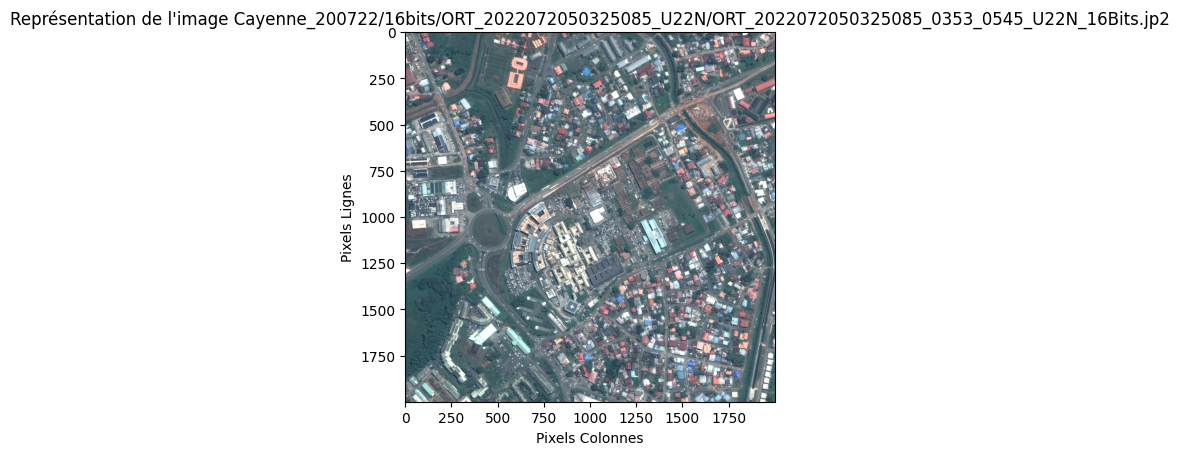

In [55]:
# The grid of raster values can be accessed as a numpy array and plotted:
with rasterio.open(filepath) as raster:
    oviews = raster.overviews(1) # list of overviews from biggest to smallest
    print(oviews)
    oview = 1 # let's look at the smallest thumbnail

    # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
    B1 = raster.read(1, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))
    B2 = raster.read(2, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))
    B3 = raster.read(3, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))
    B4 = raster.read(4, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))
        
B1a = rp.adjust_band(np.clip(B1,0,np.quantile(B1,0.97))) # normalisation min-max simple nécessite un clip d'abord étant donné les valeurs extremes
B2a = rp.adjust_band(np.clip(B2,0,np.quantile(B2,0.97)))
B3a = rp.adjust_band(np.clip(B3,0,np.quantile(B3,0.97)))
B4a = rp.adjust_band(np.clip(B4,0,np.quantile(B4,0.97)))

rgb = np.dstack((B1a,B2a,B3a))
rgbvegetal = np.dstack((B4a,B1a,B2a))

plt.imshow(rgb)
plt.title("Représentation de l'image {}".format(filepath))
plt.xlabel('Pixels Colonnes')
plt.ylabel('Pixels Lignes')


La bande infrarouge permet de détecter la végétation avec précision

Text(0, 0.5, 'Pixels Lignes')

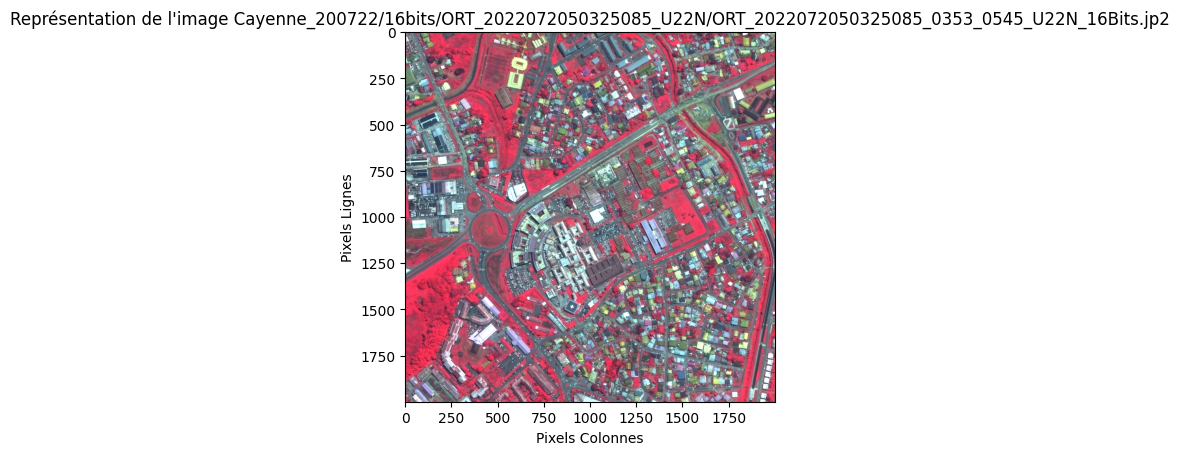

In [33]:
plt.imshow(rgbvegetal)
plt.title("Représentation de l'image {}".format(filepath))
plt.xlabel('Pixels Colonnes')
plt.ylabel('Pixels Lignes')


Récupérer le RIL GUYANE et les points associés et les représenter

La bible en manipulation avec rasterio <3
https://automating-gis-processes.github.io/CSC/notebooks/L5/raster-mosaic.html

### Passage le raster à la géométrie GPS

On peut transformer les données en GPS
On peut également avoir les limites géographique de l'image
cf ici : https://rasterio.readthedocs.io/en/latest/topics/reproject.html
On a peut-être meilleur temps de transformer les donénes RIL dans le bon EPSG mais pour la forme déjà

In [93]:
dst_crs = 'EPSG:4326'

with rasterio.open(filepath) as src:
    print(src.profile)
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    width = height = src.width # je contrains 
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rasterio.open('tmp.tif', 'w', **kwargs) as dst: # écriture de la reprojectiond ans un tiff
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs)
            


{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 2000, 'height': 2000, 'count': 4, 'crs': CRS.from_epsg(2972), 'transform': Affine(0.5, 0.0, 353000.0,
       0.0, -0.5, 545000.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'interleave': 'pixel'}


In [92]:
rasterwgs84 = rasterio.open('tmp.tif')
rasterwgs84.bounds 
# taper ça sur google maps 4.920328778395846,-52.32580589928141  (bord en ba à gauche) pour vérifier !
# ça marche :)

BoundingBox(left=-52.32580589928141, bottom=4.920328778395846, right=-52.31677510776761, top=4.929359569909651)

Maintenant on va vouloir se servir de la bounding box pour récupérer les points RIL à l'intérieur de cette zone et voir ce que ça donne

### Gestion d'une bibliothèque d'images

Dans un premier temps on liste l'ensemble des fichiers jp2 de la mosaïque que l'on veut créer

In [3]:
import glob # pour les expressions régulières
%matplotlib inline

# File and folder paths
dirpath = "Cayenne_200722/16bits/ORT_2022072050325085_U22N"

# Make a search criteria to select the DEM files
search_criteria = "*.jp2"
q = os.path.join(dirpath, search_criteria)

file_to_read = glob.glob(q)


Création de la mosaïque

In [4]:
# List for the source files
src_files_to_mosaic = []

# Iterate over raster files and add them to source -list in 'read mode'
i = 1
for fp in file_to_read:  # que de 1 à 20 pour commencer
    if (i%%20 == 0) print(i)
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)
    

#src_files_to_mosaic

Petite fonction de transformation clip + normalisation

In [5]:
def clipQuant(array,quant):
    out = rp.adjust_band(np.clip(array,0,np.quantile(array,quant)))
    return(out)

def climNormStack(raster):
    oview = 1
    B1 = raster.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    B2 = raster.read(2, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    B3 = raster.read(3, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    B4 = raster.read(4, out_shape=(1, int(src.height // oview), int(src.width // oview)))

    B1a = clipQuant(B1,0.97) # normalisation min-max simple nécessite un clip d'abord étant donné les valeurs extremes
    B2a = clipQuant(B2,0.97)
    B3a = clipQuant(B3,0.97)
    B4a = clipQuant(B4,0.97)

    rgb = np.dstack((B1a,B2a,B3a))
    
    return(rgb)

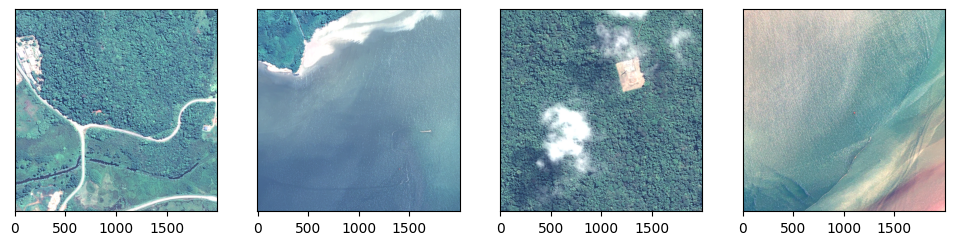

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create 4 plots next to each other
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(12, 4))

# Plot first four files
show(np.moveaxis(climNormStack(src_files_to_mosaic[0]), -1, 0), ax=ax1)
show(np.moveaxis(climNormStack(src_files_to_mosaic[1]), -1, 0), ax=ax2)
show(np.moveaxis(climNormStack(src_files_to_mosaic[2]), -1, 0), ax=ax3)
show(np.moveaxis(climNormStack(src_files_to_mosaic[3]), -1, 0), ax=ax4)# inconsistence entre imshow et show sur l'emplacement des channels
# Do not show y-ticks values in last three axis
for ax in [ax1,ax2, ax3, ax4]:
    ax.yaxis.set_visible(False)

La fameuse fusion

In [8]:
mosaic, out_trans = merge(src_files_to_mosaic[1:10])

Enorme ! il est temps de bboxer tout ça ?

## TO DO :
rasterio est confortable mais j'ai le sentilment que gdal peut permettre plus d'opérations
usage de gdal en ligne de commande à essayer ? https://automating-gis-processes.github.io/2016/Lesson7-gdal-utilities.html